In [1]:
from pathlib import Path
from tqdm import tqdm
from virtualizarr import open_virtual_dataset, open_virtual_mfdataset
from virtualizarr.parsers import HDFParser
from virtualizarr.registry import ObjectStoreRegistry
from icechunk.xarray import to_icechunk
from dask.diagnostics import ProgressBar

import obstore as obs
import xarray as xr
import icechunk
import hvplot.xarray

import warnings
warnings.filterwarnings(
  "ignore",
  message="Numcodecs codecs are not in the Zarr version 3 specification*",
  category=UserWarning
)
icechunk.set_logs_filter(
    "icechunk::storage::object_store=error"
)  # remove the warning due to the local icechunk store

In [2]:
ROOT_DIR = Path("/Volumes/T7")
RAW_FILES_DIR = ROOT_DIR / "raw_files/hackathon-meteo-france"

BUCKETS_DIR = ROOT_DIR / "buckets"
ICECHUNK_BUCKET = BUCKETS_DIR / "hackathon-meteo-france"
PREFIX_ANASTASIA = "REA/ANASTASIA"

prefix = "file:///Volumes/"

# Get file paths

In [3]:
all_files = list((RAW_FILES_DIR / "REA").rglob(f"*.nc"))

files_rea = {
    var: list((RAW_FILES_DIR / "REA").rglob(f"{var}/*.nc"))
    for var in ["tasmin", "tasmax", "tas"]
}

print({k: len(v) for k,v in files_rea.items()})
print(len(all_files))
assert sum(len(v) for v in files_rea.values()) == len(all_files)

{'tasmin': 63, 'tasmax': 72, 'tas': 70}
205


In [4]:
files_rea["tasmin"][:5]

[PosixPath('/Volumes/T7/raw_files/hackathon-meteo-france/REA/METROPOLE/ANASTASIA-V1/netcdf/day/tasmin/tasmin_France-Metro_ANASTASIA-V1_day_20180101_20181231.nc'),
 PosixPath('/Volumes/T7/raw_files/hackathon-meteo-france/REA/METROPOLE/ANASTASIA-V1/netcdf/day/tasmin/tasmin_France-Metro_ANASTASIA-V1_day_19960101_19961231.nc'),
 PosixPath('/Volumes/T7/raw_files/hackathon-meteo-france/REA/METROPOLE/ANASTASIA-V1/netcdf/day/tasmin/tasmin_France-Metro_ANASTASIA-V1_day_19950101_19951231.nc'),
 PosixPath('/Volumes/T7/raw_files/hackathon-meteo-france/REA/METROPOLE/ANASTASIA-V1/netcdf/day/tasmin/tasmin_France-Metro_ANASTASIA-V1_day_19930101_19931231.nc'),
 PosixPath('/Volumes/T7/raw_files/hackathon-meteo-france/REA/METROPOLE/ANASTASIA-V1/netcdf/day/tasmin/tasmin_France-Metro_ANASTASIA-V1_day_19900101_19901231.nc')]

In [5]:
storage = icechunk.local_filesystem_storage(
    # optional: we can add a prefix here
    path=ICECHUNK_BUCKET
)
config = icechunk.RepositoryConfig.default()
config.set_virtual_chunk_container(
    icechunk.VirtualChunkContainer(
        url_prefix=prefix,
        store=icechunk.local_filesystem_store(path=RAW_FILES_DIR),
    )
)

repo = icechunk.Repository.open_or_create(
    storage,
    config,
    authorize_virtual_chunk_access={prefix: None}
)

In [6]:
session = repo.writable_session("main")
vds.vz.to_icechunk(session.store)
session.commit("Import first dataset")

NameError: name 'vds' is not defined

# Zarr

## Load data

In [5]:
files_rea["tasmin"][-3:]

[PosixPath('/Volumes/T7/raw_files/hackathon-meteo-france/REA/METROPOLE/ANASTASIA-V1/netcdf/day/tasmin/tasmin_France-Metro_ANASTASIA-V1_day_19920101_19921231.nc'),
 PosixPath('/Volumes/T7/raw_files/hackathon-meteo-france/REA/METROPOLE/ANASTASIA-V1/netcdf/day/tasmin/tasmin_France-Metro_ANASTASIA-V1_day_19970101_19971231.nc'),
 PosixPath('/Volumes/T7/raw_files/hackathon-meteo-france/REA/METROPOLE/ANASTASIA-V1/netcdf/day/tasmin/tasmin_France-Metro_ANASTASIA-V1_day_20190101_20191231.nc')]

In [6]:
datasets = {}

for var, files in files_rea.items():
    datasets[var] = []
    for f in tqdm(files):
        ds = xr.open_dataset(f, chunks={})
        datasets[var].append(ds)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:00<00:00, 103.51it/s]


In [7]:
data = {}

for var, ds_list in datasets.items():
    ds = xr.combine_by_coords(ds_list, combine_attrs='drop_conflicts', data_vars='all')
    data[var] = ds

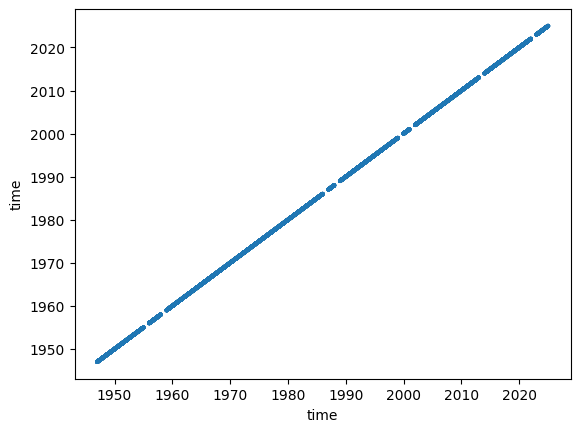

In [8]:
data["tas"].time.plot.scatter(marker=".", edgecolor="none")

In [9]:
dt = xr.DataTree.from_dict(data)

In [10]:
dt

<xarray.DataTree>
Group: /
├── Group: /tasmin
│       Dimensions:         (time: 23010, y: 1081, x: 1171, nbounds: 4)
│       Coordinates:
│         * time            (time) datetime64[ns] 184kB 1947-01-01 ... 2024-12-31
│         * y               (y) float64 9kB 1.605e+06 1.606e+06 ... 2.684e+06 2.685e+06
│         * x               (x) float64 9kB 4e+04 4.1e+04 4.2e+04 ... 1.209e+06 1.21e+06
│           lon             (y, x) float64 10MB dask.array<chunksize=(1081, 1171), meta=np.ndarray>
│           lat             (y, x) float64 10MB dask.array<chunksize=(1081, 1171), meta=np.ndarray>
│       Dimensions without coordinates: nbounds
│       Data variables:
│           lat_bnds        (time, y, x, nbounds) float64 932GB dask.array<chunksize=(365, 1081, 1171, 4), meta=np.ndarray>
│           lon_bnds        (time, y, x, nbounds) float64 932GB dask.array<chunksize=(365, 1081, 1171, 4), meta=np.ndarray>
│           tasmin          (time, y, x) float32 117GB dask.array<chunksize=(1, 1081, 1171), meta=np.ndarray>
│           LambertParisII  (time) int32 92kB -2147483647 -2147483647 ... -2147483647
│       Attributes: (12/28)
│           title:                         Anastasia-V1
│           keywords:                      temperature, climate, France, surface air ...
│           Conventions:                   CF-1.6, ACDD-1.3
│           license:                       http://www.meteofrance.fr/licence
│           institution:                   Meteo-France
│           acknowledgment:                DCSC/EMA
│           ...                            ...
│           publisher_url:                 http://www.meteofrance.fr
│           publisher_email:               dcsc_ema@meteo.fr
│           source:                        Spatialized surface air temperature observ...
│           comment:                       Dataset produced by Meteo-France as part o...
│           standard_name_vocabulary:      DCSC/EMA
│           references:                    Besson, François & Dubuisson, Brigitte & E...
├── Group: /tasmax
│       Dimensions:         (time: 26299, y: 1081, x: 1171, nbounds: 4)
│       Coordinates:
│         * time            (time) datetime64[ns] 210kB 1947-01-01 ... 2024-12-31
│         * y               (y) float64 9kB 1.605e+06 1.606e+06 ... 2.684e+06 2.685e+06
│         * x               (x) float64 9kB 4e+04 4.1e+04 4.2e+04 ... 1.209e+06 1.21e+06
│           lon             (y, x) float64 10MB dask.array<chunksize=(1081, 1171), meta=np.ndarray>
│           lat             (y, x) float64 10MB dask.array<chunksize=(1081, 1171), meta=np.ndarray>
│       Dimensions without coordinates: nbounds
│       Data variables:
│           lat_bnds        (time, y, x, nbounds) float64 1TB dask.array<chunksize=(365, 1081, 1171, 4), meta=np.ndarray>
│           lon_bnds        (time, y, x, nbounds) float64 1TB dask.array<chunksize=(365, 1081, 1171, 4), meta=np.ndarray>
│           tasmax          (time, y, x) float32 133GB dask.array<chunksize=(1, 1081, 1171), meta=np.ndarray>
│           LambertParisII  (time) int32 105kB -2147483647 -2147483647 ... -2147483647
│       Attributes: (12/28)
│           title:                         Anastasia-V1
│           keywords:                      temperature, climate, France, surface air ...
│           Conventions:                   CF-1.6, ACDD-1.3
│           license:                       http://www.meteofrance.fr/licence
│           institution:                   Meteo-France
│           acknowledgment:                DCSC/EMA
│           ...                            ...
│           publisher_url:                 http://www.meteofrance.fr
│           publisher_email:               dcsc_ema@meteo.fr
│           source:                        Spatialized surface air temperature observ...
│           comment:                       Dataset produced by Meteo-France as part o...
│           standard_name_vocabulary:      DCSC/EMA
│           references:                    Besson, François & D

## Save to zarr store

In [11]:
storage = icechunk.local_filesystem_storage(
    # optional: we can add a prefix here
    path=ICECHUNK_BUCKET / PREFIX_ANASTASIA
)
config = icechunk.RepositoryConfig.default()

repo = icechunk.Repository.open_or_create(
    storage,
    config,
    authorize_virtual_chunk_access={prefix: None}
)

In [12]:
def process_ds(ds, var_name: str):
    ds = ds.drop_vars(["lat_bnds", "lon_bnds"])
    # 14M on disk, ~44M in memory
    ds = ds[var_name].chunk({"time": 32, "y": 600, "x": 600})
    return ds


def save_dataset(ds, repo, path: str):
    session = repo.writable_session("main")
    with ProgressBar():
        to_icechunk(ds, session, group=path)
    msg = f"Import dataset {path}"
    snapshot = session.commit(msg)
    print(f"{snapshot} - {msg}")

In [ ]:
for var_name in ["tas", "tasmin", "tasmax"]:
    x = process_ds(dt[var_name].dataset, var_name=var_name)
    save_dataset(x, repo, path=var_name)

[########################################] | 100% Completed | 349.70 s
[##                                      ] | 5% Completed | 25.44 sms

In [15]:
for var_name in ["tasmin", "tasmax"]:
    x = process_ds(dt[var_name].dataset, var_name=var_name)
    save_dataset(x, repo, path=var_name)

[########################################] | 100% Completed | 12m 2ss
BC3Y1X0JFT1ZY4AZ1HMG - Import dataset tasmin
[##############################          ] | 76% Completed | 11m 41ss


KeyboardInterrupt: 

In [34]:
ancestry = list(repo.ancestry(branch="main"))

In [35]:
for s in ancestry:
    print(s.id, s.written_at, s.message)

BC3Y1X0JFT1ZY4AZ1HMG 2025-12-02 12:27:52.956263+00:00 Import dataset tasmin
A5HYA63XM1S0ZW40SXVG 2025-12-02 11:56:18.329027+00:00 Import dataset tas
1CECHNKREP0F1RSTCMT0 2025-12-02 11:50:23.708711+00:00 Repository initialized


In [38]:
expiry_time = ancestry[0].written_at
print(expiry_time)

2025-12-02 12:27:52.956263+00:00


In [39]:
repo.expire_snapshots(older_than=expiry_time)

{'A5HYA63XM1S0ZW40SXVG'}

In [42]:
repo.garbage_collect(expiry_time)

GCSummary(bytes_deleted=63198472093, chunks_deleted=4693, manifests_deleted=0, snapshots_deleted=1, attributes_deleted=0, transaction_logs_deleted=1)

In [13]:
for var_name in ["tasmax"]:
    x = process_ds(dt[var_name].dataset, var_name=var_name)
    save_dataset(x, repo, path=var_name)

[########################################] | 100% Completed | 421.24 s
WBW89G8S47YDJ32D4DB0 - Import dataset tasmax


In [14]:
ancestry = list(repo.ancestry(branch="main"))

In [15]:
for s in ancestry:
    print(s.id, s.written_at, s.message)

WBW89G8S47YDJ32D4DB0 2025-12-02 13:02:11.190523+00:00 Import dataset tasmax
BC3Y1X0JFT1ZY4AZ1HMG 2025-12-02 12:27:52.956263+00:00 Import dataset tasmin
1CECHNKREP0F1RSTCMT0 2025-12-02 11:50:23.708711+00:00 Repository initialized


In [16]:
expiry_time = ancestry[0].written_at
print(expiry_time)

2025-12-02 13:02:11.190523+00:00


In [17]:
repo.expire_snapshots(older_than=expiry_time)

{'BC3Y1X0JFT1ZY4AZ1HMG'}

In [18]:
repo.garbage_collect(expiry_time)

GCSummary(bytes_deleted=34001053681, chunks_deleted=2507, manifests_deleted=0, snapshots_deleted=1, attributes_deleted=0, transaction_logs_deleted=1)

# Check

In [3]:
storage = icechunk.local_filesystem_storage(
    # optional: we can add a prefix here
    path=ICECHUNK_BUCKET / PREFIX_ANASTASIA
)
new_repo = icechunk.Repository.open_or_create(
    storage,
    authorize_virtual_chunk_access={prefix: None}
)
new_session = new_repo.readonly_session("main")

dt = xr.open_datatree(new_session.store, engine='zarr', zarr_format=3, chunks={})
dt

<xarray.DataTree>
Group: /
├── Group: /tas
│       Dimensions:  (time: 25569, y: 1081, x: 1171)
│       Coordinates:
│         * time     (time) datetime64[ns] 205kB 1947-01-01 1947-01-02 ... 2024-12-31
│         * y        (y) float64 9kB 1.605e+06 1.606e+06 ... 2.684e+06 2.685e+06
│         * x        (x) float64 9kB 4e+04 4.1e+04 4.2e+04 ... 1.209e+06 1.21e+06
│           lat      (y, x) float64 10MB dask.array<chunksize=(600, 600), meta=np.ndarray>
│           lon      (y, x) float64 10MB dask.array<chunksize=(600, 600), meta=np.ndarray>
│       Data variables:
│           tas      (time, y, x) float32 129GB dask.array<chunksize=(32, 600, 600), meta=np.ndarray>
├── Group: /tasmax
│       Dimensions:  (time: 26299, y: 1081, x: 1171)
│       Coordinates:
│         * time     (time) datetime64[ns] 210kB 1947-01-01 1947-01-02 ... 2024-12-31
│         * y        (y) float64 9kB 1.605e+06 1.606e+06 ... 2.684e+06 2.685e+06
│         * x        (x) float64 9kB 4e+04 4.1e+04 4.2e+04 ... 1.209e+06 1.21e+06
│           lat      (y, x) float64 10MB dask.array<chunksize=(600, 600), meta=np.ndarray>
│           lon      (y, x) float64 10MB dask.array<chunksize=(600, 600), meta=np.ndarray>
│       Data variables:
│           tasmax   (time, y, x) float32 133GB dask.array<chunksize=(32, 600, 600), meta=np.ndarray>
└── Group: /tasmin
        Dimensions:  (time: 23010, y: 1081, x: 1171)
        Coordinates:
          * time     (time) datetime64[ns] 184kB 1947-01-01 1947-01-02 ... 2024-12-31
          * y        (y) float64 9kB 1.605e+06 1.606e+06 ... 2.684e+06 2.685e+06
          * x        (x) float64 9kB 4e+04 4.1e+04 4.2e+04 ... 1.209e+06 1.21e+06
            lat      (y, x) float64 10MB dask.array<chunksize=(600, 600), meta=np.ndarray>
            lon      (y, x) float64 10MB dask.array<chunksize=(600, 600), meta=np.ndarray>
        Data variables:
            tasmin   (time, y, x) float32 117GB dask.array<chunksize=(32, 600, 600), meta=np.ndarray>

In [5]:
dt["tasmax"].tasmax.isel(time=100).hvplot()

:Image   [x,y]   (Daily Maximum Near-Surface Air Temperature)

# Archive - Virtualizarr

## Load data

In [30]:
project_url = f"file://{RAW_FILES_DIR}"
store = obs.store.LocalStore(prefix=RAW_FILES_DIR)

registry = ObjectStoreRegistry({project_url: store})

In [31]:
path = "RCM/EURO-CORDEX/EUR-12/NorESM2-MM/r1i1p1f1/CNRM-ALADIN64E1/ssp370/day/rldsAdjust/version-hackathon-102025/rldsAdjust_FR-Metro_NorESM2-MM_ssp370_r1i1p1f1_CNRM-MF_CNRM-ALADIN64E1_v1-r1_MF-CDFt-SAFRAN-1985-2014_day_20150101-21001231.nc"

parser = HDFParser()
vds = open_virtual_dataset(
  url=f"{project_url}/{path}",
  parser=parser,
  registry=registry,
)

In [21]:
vds.nbytes / 2**30

2.2443750612437725

### REA - open and combine

In [51]:
all_files = list((RAW_FILES_DIR / "REA").rglob(f"*.nc"))

files = {
    var: list((RAW_FILES_DIR / "REA").rglob(f"{var}/*.nc"))
    for var in ["tasmin", "tasmax", "tas"]
}

print({k: len(v) for k,v in files.items()})
print(len(all_files))
assert sum(len(v) for v in files.values()) == len(all_files)

{'tasmin': 63, 'tasmax': 72, 'tas': 70}
205


In [45]:
files["tasmin"][-3:]

[PosixPath('/Volumes/T7/raw_files/hackathon-meteo-france/REA/METROPOLE/ANASTASIA-V1/netcdf/day/tasmin/tasmin_France-Metro_ANASTASIA-V1_day_19920101_19921231.nc'),
 PosixPath('/Volumes/T7/raw_files/hackathon-meteo-france/REA/METROPOLE/ANASTASIA-V1/netcdf/day/tasmin/tasmin_France-Metro_ANASTASIA-V1_day_19970101_19971231.nc'),
 PosixPath('/Volumes/T7/raw_files/hackathon-meteo-france/REA/METROPOLE/ANASTASIA-V1/netcdf/day/tasmin/tasmin_France-Metro_ANASTASIA-V1_day_20190101_20191231.nc')]

In [61]:
virtual_datasets = []

for f in tqdm(files["tasmin"]):
    vds = open_virtual_dataset(
        url=str(f),
        parser=parser,
        registry=registry,
        loadable_variables=None
    )
    virtual_datasets.append(vds)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 63/63 [00:03<00:00, 20.39it/s]


In [62]:
[v.coords for v in virtual_datasets[:5]]

[Coordinates:
   * x        (x) float64 9kB 4e+04 4.1e+04 4.2e+04 ... 1.209e+06 1.21e+06
   * y        (y) float64 9kB 1.605e+06 1.606e+06 ... 2.684e+06 2.685e+06
   * time     (time) datetime64[ns] 3kB 2018-01-01 2018-01-02 ... 2018-12-31
     lon      (y, x) float64 10MB ManifestArray<shape=(1081, 1171), dtype=floa...
     lat      (y, x) float64 10MB ManifestArray<shape=(1081, 1171), dtype=floa...,
 Coordinates:
   * x        (x) float64 9kB 4e+04 4.1e+04 4.2e+04 ... 1.209e+06 1.21e+06
   * y        (y) float64 9kB 1.605e+06 1.606e+06 ... 2.684e+06 2.685e+06
   * time     (time) datetime64[ns] 3kB 1996-01-01 1996-01-02 ... 1996-12-31
     lon      (y, x) float64 10MB ManifestArray<shape=(1081, 1171), dtype=floa...
     lat      (y, x) float64 10MB ManifestArray<shape=(1081, 1171), dtype=floa...,
 Coordinates:
   * x        (x) float64 9kB 4e+04 4.1e+04 4.2e+04 ... 1.209e+06 1.21e+06
   * y        (y) float64 9kB 1.605e+06 1.606e+06 ... 2.684e+06 2.685e+06
   * time     (time) dateti

In [64]:
xr.combine_nested(
    virtual_datasets,
    combine_attrs="drop_conflicts",
    concat_dim="time",
    coords="minimal"
)

/var/folders/5z/39x2t1v937l2htjdr2vrlnhr0000gn/T/ipykernel_12819/1955991130.py:1: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  xr.combine_nested(virtual_datasets, combine_attrs="drop_conflicts", concat_dim="time", coords="minimal")


TypeError: Could not find a Chunk Manager which recognises type <class 'virtualizarr.manifests.array.ManifestArray'>

## Save as virtual store